**Disclaimer:** When I created the first version of this notebook, I copied a lot of boilerplate code from another project. I somehow missed that `KFold` doesn't make sense to use with this dataset. Even worse, I set `shuffle=True`. This introduced leakage into the pipeline, meaning the model used future data to train and was validated on past data. Despite this obvious mistake, the code scored high both on the public leaderboard and in cross-validation. This is an obvious error and indicates heavy overfitting to the public leaderboard. Therefore, I advise against using the code or output from notebook versions 8 and below (especially version 1).

# Configs and Imports

In [1]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GroupKFold, KFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.base import clone
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [2]:
N_FOLDS = 5
N_REPEATS = 1
SEED = 27

# Loading and Processing The Datasets

In [3]:
train = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv')
test = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv')

test_ids = test.id.values

train.shape, test.shape

((7340, 18), (397, 8))

In [4]:
missing_cols_in_test = [
    'shutdown',
    'mini_shutdown',
    'blackout',
    'mov_change',
    'frankfurt_shutdown',
    'precipitation',
    'snow',
    'user_activity_1',
    'user_activity_2'
]

train = train.drop(missing_cols_in_test, axis=1, errors='ignore')
train = train.sort_values("date").reset_index(drop=True)
train.shape, test.shape

((7340, 9), (397, 8))

In [5]:
train

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,Prague_1_2020-12-05
1,Prague_2,2020-12-05,4154.0,NaN,0,0,0,0,Prague_2_2020-12-05
2,Prague_3,2020-12-05,4091.0,NaN,0,0,0,0,Prague_3_2020-12-05
3,Budapest_1,2020-12-05,4623.0,NaN,0,0,0,0,Budapest_1_2020-12-05
4,Brno_1,2020-12-05,6447.0,NaN,0,0,0,0,Brno_1_2020-12-05
...,...,...,...,...,...,...,...,...,...
7335,Brno_1,2024-03-15,10777.0,NaN,0,0,0,0,Brno_1_2024-03-15
7336,Prague_3,2024-03-15,6408.0,NaN,0,0,0,0,Prague_3_2024-03-15
7337,Prague_1,2024-03-15,11917.0,NaN,0,0,0,0,Prague_1_2024-03-15
7338,Prague_2,2024-03-15,7140.0,NaN,0,0,0,0,Prague_2_2024-03-15


In [6]:
test

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16
1,Prague_1,2024-03-17,NaN,0,0,0,0,Prague_1_2024-03-17
2,Prague_1,2024-03-18,NaN,0,0,0,0,Prague_1_2024-03-18
3,Prague_1,2024-03-19,NaN,0,0,0,0,Prague_1_2024-03-19
4,Prague_1,2024-03-20,NaN,0,0,0,0,Prague_1_2024-03-20
...,...,...,...,...,...,...,...,...
392,Budapest_1,2024-05-11,NaN,0,0,0,0,Budapest_1_2024-05-11
393,Budapest_1,2024-05-12,NaN,0,0,0,0,Budapest_1_2024-05-12
394,Budapest_1,2024-05-13,NaN,0,0,0,0,Budapest_1_2024-05-13
395,Budapest_1,2024-05-14,NaN,0,0,0,0,Budapest_1_2024-05-14


In [7]:
for df in [train, test]:
    df['holiday_name'] = df['holiday_name'].fillna('').astype('category')
    df['warehouse'] = df['warehouse'].astype('category')
    
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['season'] = (df['month'] % 12 + 3) // 3
    df['season'] = df['season'].astype(int)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Reference: https://www.kaggle.com/code/yunsuxiaozi/rohlik-orders-baseline
    df['group'] = (df['year']-2020)*48+df['month']*4+df['day']//7
    
    df['day_before_holiday'] = df['holiday'].shift().fillna(0)
    df['day_after_holiday'] = df['holiday'].shift(-1).fillna(0)
    df['day_before_school_holiday'] = df['school_holidays'].shift().fillna(0)
    df['day_after_school_holiday'] = df['school_holidays'].shift(-1).fillna(0)
    df['day_before_winter_school_holiday'] = df['winter_school_holidays'].shift().fillna(0)
    df['day_after_winter_school_holiday'] = df['winter_school_holidays'].shift(-1).fillna(0)
    df['holiday_and_shops_closed'] = df['holiday'] * df['shops_closed']
    df['week_before_holiday'] = df['holiday'].shift(-7).rolling(window=7, min_periods=1).sum().shift(1).fillna(0).apply(lambda x: 1 if x > 0 else 0)


cat_features = [col for col in train.columns if train[col].dtype.name == 'category']

train.shape, test.shape

((7340, 27), (397, 26))

In [8]:
train

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,year,...,is_weekend,group,day_before_holiday,day_after_holiday,day_before_school_holiday,day_after_school_holiday,day_before_winter_school_holiday,day_after_winter_school_holiday,holiday_and_shops_closed,week_before_holiday
0,Prague_1,2020-12-05,6895.0,,0,0,0,0,Prague_1_2020-12-05,2020,...,1,48,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,Prague_2,2020-12-05,4154.0,,0,0,0,0,Prague_2_2020-12-05,2020,...,1,48,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,Prague_3,2020-12-05,4091.0,,0,0,0,0,Prague_3_2020-12-05,2020,...,1,48,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,Budapest_1,2020-12-05,4623.0,,0,0,0,0,Budapest_1_2020-12-05,2020,...,1,48,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,Brno_1,2020-12-05,6447.0,,0,0,0,0,Brno_1_2020-12-05,2020,...,1,48,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7335,Brno_1,2024-03-15,10777.0,,0,0,0,0,Brno_1_2024-03-15,2024,...,0,206,0.0,0.0,0.0,0.0,0.0,0.0,0,0
7336,Prague_3,2024-03-15,6408.0,,0,0,0,0,Prague_3_2024-03-15,2024,...,0,206,0.0,0.0,0.0,0.0,0.0,0.0,0,0
7337,Prague_1,2024-03-15,11917.0,,0,0,0,0,Prague_1_2024-03-15,2024,...,0,206,0.0,0.0,0.0,0.0,0.0,0.0,0,0
7338,Prague_2,2024-03-15,7140.0,,0,0,0,0,Prague_2_2024-03-15,2024,...,0,206,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [9]:
test

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,year,month,...,is_weekend,group,day_before_holiday,day_after_holiday,day_before_school_holiday,day_after_school_holiday,day_before_winter_school_holiday,day_after_winter_school_holiday,holiday_and_shops_closed,week_before_holiday
0,Prague_1,2024-03-16,,0,0,0,0,Prague_1_2024-03-16,2024,3,...,1,206,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,Prague_1,2024-03-17,,0,0,0,0,Prague_1_2024-03-17,2024,3,...,1,206,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,Prague_1,2024-03-18,,0,0,0,0,Prague_1_2024-03-18,2024,3,...,0,206,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,Prague_1,2024-03-19,,0,0,0,0,Prague_1_2024-03-19,2024,3,...,0,206,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,Prague_1,2024-03-20,,0,0,0,0,Prague_1_2024-03-20,2024,3,...,0,206,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,Budapest_1,2024-05-11,,0,0,0,0,Budapest_1_2024-05-11,2024,5,...,1,213,0.0,0.0,0.0,0.0,0.0,0.0,0,0
393,Budapest_1,2024-05-12,,0,0,0,0,Budapest_1_2024-05-12,2024,5,...,1,213,0.0,0.0,0.0,0.0,0.0,0.0,0,0
394,Budapest_1,2024-05-13,,0,0,0,0,Budapest_1_2024-05-13,2024,5,...,0,213,0.0,0.0,0.0,0.0,0.0,0.0,0,0
395,Budapest_1,2024-05-14,,0,0,0,0,Budapest_1_2024-05-14,2024,5,...,0,214,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [10]:
X_train = train.drop(['date', 'orders', 'id'], axis=1)
y_train = train['orders']

X_test = test.drop(['date', 'id'], axis=1)

# Training Base Models

In [11]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS, n_repeats=N_REPEATS):
        self.model = model
        self.n_folds = n_folds
        self.n_repeats = n_repeats

    def fit(self, X, y, is_ensemble=False):
        print(f'Training {self.model.__class__.__name__}')
        
        if is_ensemble:
            kfs = KFold(n_splits=self.n_folds).split(X, y)
        else:
            kfs = GroupKFold(n_splits=self.n_folds).split(X, y, X['group'])
        
        scores = []
        oof_preds = np.zeros(len(X), dtype=float)
        for fold_idx, (train_idx, val_idx) in enumerate(kfs):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = mean_absolute_percentage_error(y_val, y_pred)
            scores.append(score)
            
            print(f'--- Fold {fold_idx + 1} - MAPE: {score:.6f}')
            
            oof_preds[val_idx] = y_pred
            
        print(f'\n------ MAPE: {np.mean(scores):.6f} ± {np.std(scores):.6f}\n\n')
            
        return m, scores, oof_preds
        
    def fit_predict(self, X, y, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(X, y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [12]:
xgb_params = {
    "booster": "gbtree",
    "colsample_bylevel": 0.9673859327785632,
    "colsample_bynode": 0.4923751425658328,
    "colsample_bytree": 0.912934729761709,
    "enable_categorical": True,
    "gamma": 6.370448095325031,
    "grow_policy": "lossguide",
    "learning_rate": 0.012256291098871963,
    "max_depth": 44,
    "min_child_weight": 6.020222516598196,
    "n_estimators": 3968,
    "n_jobs": -1,
    "random_state": SEED,
    "reg_alpha": 6.594466467943319,
    "reg_lambda": 3.668453209568534,
    "subsample": 0.8380164729493292,
    "verbosity": 0
}

cb_params = {
    "bootstrap_type": "MVS",
    "border_count": 236,
    "colsample_bylevel": 0.9895796854882428,
    "depth": 6,
    "grow_policy": "SymmetricTree",
    "iterations": 4727,
    "l2_leaf_reg": 8.243537067932515,
    "loss_function": "Quantile",
    "min_data_in_leaf": 41,
    "random_state": SEED,
    "random_strength": 0.8499226947970046,
    "subsample": 0.7467840216120686,
    "thread_count": -1,
    "verbose": False
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.9547441579422116,
    "learning_rate": 0.04406871820205758,
    "min_child_samples": 8,
    "min_child_weight": 0.5163384032966228,
    "min_split_gain": 0.18807271127987724,
    "n_estimators": 663,
    "n_jobs": -1,
    "num_leaves": 48,
    "random_state": SEED,
    "reg_alpha": 5.4660768249665646,
    "reg_lambda": 5.974261145462608,
    "subsample": 0.039552743069246055,
    "verbose": -1
}

In [13]:
xgb_model = XGBRegressor(**xgb_params)
xgb_trainer = Trainer(xgb_model)
xgb_model, xgb_scores, xgb_oof_preds = xgb_trainer.fit(X_train, y_train)
xgb_test_preds = xgb_trainer.fit_predict(X_train, y_train, X_test)

Training XGBRegressor
--- Fold 1 - MAPE: 0.037222
--- Fold 2 - MAPE: 0.044790
--- Fold 3 - MAPE: 0.041717
--- Fold 4 - MAPE: 0.043972
--- Fold 5 - MAPE: 0.035090

------ MAPE: 0.040558 ± 0.003793




In [14]:
cb_model = CatBoostRegressor(**cb_params, cat_features=cat_features)
cb_trainer = Trainer(cb_model)
cb_model, cb_scores, cb_oof_preds = cb_trainer.fit(X_train, y_train)
cb_test_preds = cb_trainer.fit_predict(X_train, y_train, X_test)

Training CatBoostRegressor
--- Fold 1 - MAPE: 0.035243
--- Fold 2 - MAPE: 0.047450
--- Fold 3 - MAPE: 0.042475
--- Fold 4 - MAPE: 0.042580
--- Fold 5 - MAPE: 0.037117

------ MAPE: 0.040973 ± 0.004347




In [15]:
lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
lgbm_model, lgbm_scores, lgbm_oof_preds = lgbm_trainer.fit(X_train, y_train)
lgbm_test_preds = lgbm_trainer.fit_predict(X_train, y_train, X_test)

Training LGBMRegressor
--- Fold 1 - MAPE: 0.036573
--- Fold 2 - MAPE: 0.043283
--- Fold 3 - MAPE: 0.040110
--- Fold 4 - MAPE: 0.043560
--- Fold 5 - MAPE: 0.036453

------ MAPE: 0.039996 ± 0.003091




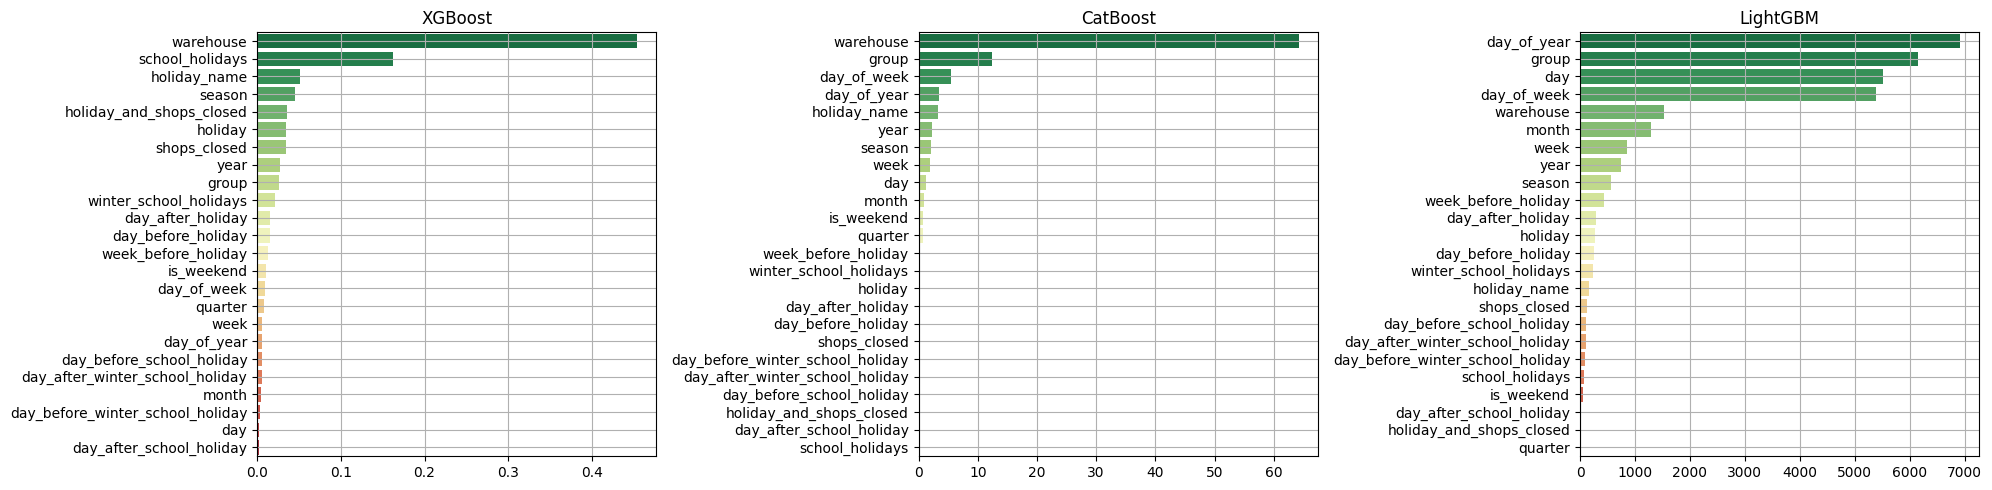

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

palette = sns.color_palette("RdYlGn_r", len(X_train.columns))

xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(y=xgb_importances.index, x=xgb_importances.values, orient='h', ax=axs[0], palette=palette)
axs[0].set_title('XGBoost')
axs[0].grid(True)

cb_importances = pd.Series(cb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(y=cb_importances.index, x=cb_importances.values, orient='h', ax=axs[1], palette=palette)
axs[1].set_title('CatBoost')
axs[1].grid(True)

lgbm_importances = pd.Series(lgbm_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(y=lgbm_importances.index, x=lgbm_importances.values, orient='h', ax=axs[2], palette=palette)
axs[2].set_title('LightGBM')
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Ensemble

In [17]:
_X_train = pd.DataFrame(np.column_stack([
    xgb_oof_preds,
    cb_oof_preds, 
    lgbm_oof_preds
]))

_X_test = pd.DataFrame(np.column_stack([
    xgb_test_preds,
    cb_test_preds,
    lgbm_test_preds
]))

In [18]:
_X_train

,0,1,2
0,7272.700195,7179.034145,7057.548632
1,4301.243652,4230.857984,4276.277260
2,4242.850586,4073.075676,4167.326032
3,4742.489258,4652.800380,4698.704989
4,6565.661621,6288.005049,6479.407618
...,...,...,...
7335,10503.431641,10338.883901,10603.889486
7336,6197.609375,6266.108438,6364.421035
7337,11742.558594,11539.881506,11905.596338
7338,6976.014160,7005.410128,7184.142444


In [19]:
_X_test

,0,1,2
0,10482.395508,10645.844105,10611.626513
1,10254.832031,10356.188015,10215.903477
2,9828.788086,9846.502504,9795.282982
3,9659.522461,9560.396215,9564.078421
4,9612.155273,9576.718028,9564.948950
...,...,...,...
392,7376.083496,7029.516023,7136.595008
393,6809.251465,6543.552210,6693.154264
394,6821.954102,6522.443090,6682.291817
395,7068.486816,6538.088649,6730.874885


In [20]:
ridge_model = Ridge()
ridge_trainer = Trainer(ridge_model, n_repeats=1)
ridge_model, ridge_scores, ridge_oof_preds = ridge_trainer.fit(_X_train, y_train, is_ensemble=True)
ridge_test_preds = ridge_trainer.fit_predict(_X_train, y_train, _X_test)

Training Ridge
--- Fold 1 - MAPE: 0.034317
--- Fold 2 - MAPE: 0.041535
--- Fold 3 - MAPE: 0.039407
--- Fold 4 - MAPE: 0.041708
--- Fold 5 - MAPE: 0.036674

------ MAPE: 0.038728 ± 0.002860




In [21]:
lasso_model = Lasso()
lasso_trainer = Trainer(lasso_model, n_repeats=1)
lasso_model, lasso_scores, lasso_oof_preds = lasso_trainer.fit(_X_train, y_train, is_ensemble=True)
lasso_test_preds = lasso_trainer.fit_predict(_X_train, y_train, _X_test)

Training Lasso
--- Fold 1 - MAPE: 0.034324
--- Fold 2 - MAPE: 0.041572
--- Fold 3 - MAPE: 0.039432
--- Fold 4 - MAPE: 0.041696
--- Fold 5 - MAPE: 0.036657

------ MAPE: 0.038736 ± 0.002866




In [22]:
ridge_cv_model = RidgeCV()
ridge_cv_trainer = Trainer(ridge_cv_model, n_repeats=1)
ridge_cv_model, ridge_cv_scores, ridge_cv_oof_preds = ridge_cv_trainer.fit(_X_train, y_train, is_ensemble=True)
ridge_cv_test_preds = ridge_cv_trainer.fit_predict(_X_train, y_train, _X_test)

Training RidgeCV
--- Fold 1 - MAPE: 0.034317
--- Fold 2 - MAPE: 0.041536
--- Fold 3 - MAPE: 0.039407
--- Fold 4 - MAPE: 0.041708
--- Fold 5 - MAPE: 0.036674

------ MAPE: 0.038729 ± 0.002860




In [23]:
lasso_cv_model = LassoCV()
lasso_cv_trainer = Trainer(lasso_cv_model, n_repeats=1)
lasso_cv_model, lasso_cv_scores, lasso_cv_oof_preds = lasso_cv_trainer.fit(_X_train, y_train, is_ensemble=True)
lasso_cv_test_preds = lasso_cv_trainer.fit_predict(_X_train, y_train, _X_test)

Training LassoCV
--- Fold 1 - MAPE: 0.034332
--- Fold 2 - MAPE: 0.041455
--- Fold 3 - MAPE: 0.039215
--- Fold 4 - MAPE: 0.041610
--- Fold 5 - MAPE: 0.036625

------ MAPE: 0.038648 ± 0.002818




# Visualizing The Results

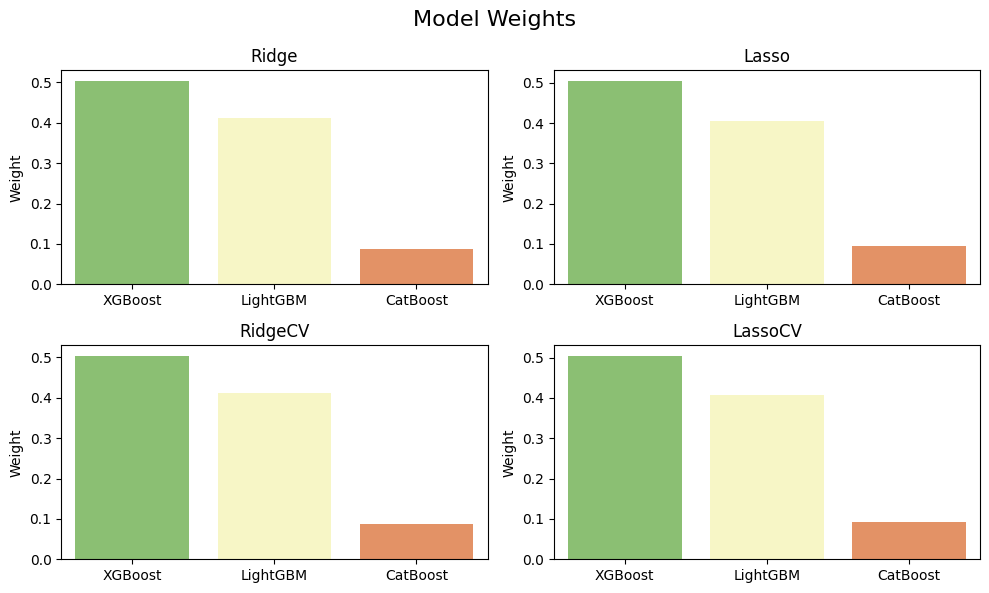

In [24]:
models = [ridge_model, lasso_model, ridge_cv_model, lasso_cv_model]
model_names = [
    'XGBoost',
    'CatBoost',
    'LightGBM',
]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
for ax, model in zip(axes.flatten(), models):
    weights = pd.Series(model.coef_, index=model_names).sort_values(ascending=False)
    sns.barplot(x=weights.index, y=weights.values, ax=ax, palette='RdYlGn_r')
    ax.set_title(f'{model.__class__.__name__}')
    ax.set_ylabel('Weight')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

fig.suptitle('Model Weights', fontsize=16)
plt.tight_layout()
plt.show()

In [25]:
scores = pd.DataFrame({
    xgb_model.__class__.__name__: xgb_scores,
    lgbm_model.__class__.__name__: lgbm_scores,
    cb_model.__class__.__name__: cb_scores,
    ridge_model.__class__.__name__: ridge_scores,
    ridge_cv_model.__class__.__name__: ridge_cv_scores,
    lasso_model.__class__.__name__: lasso_scores,
    lasso_cv_model.__class__.__name__: lasso_cv_scores
})

mean_scores = scores.mean().sort_values(ascending=False)
x_min = mean_scores.min() - 0.05 * mean_scores.min()
x_max = mean_scores.max() + 0.05 * mean_scores.max()

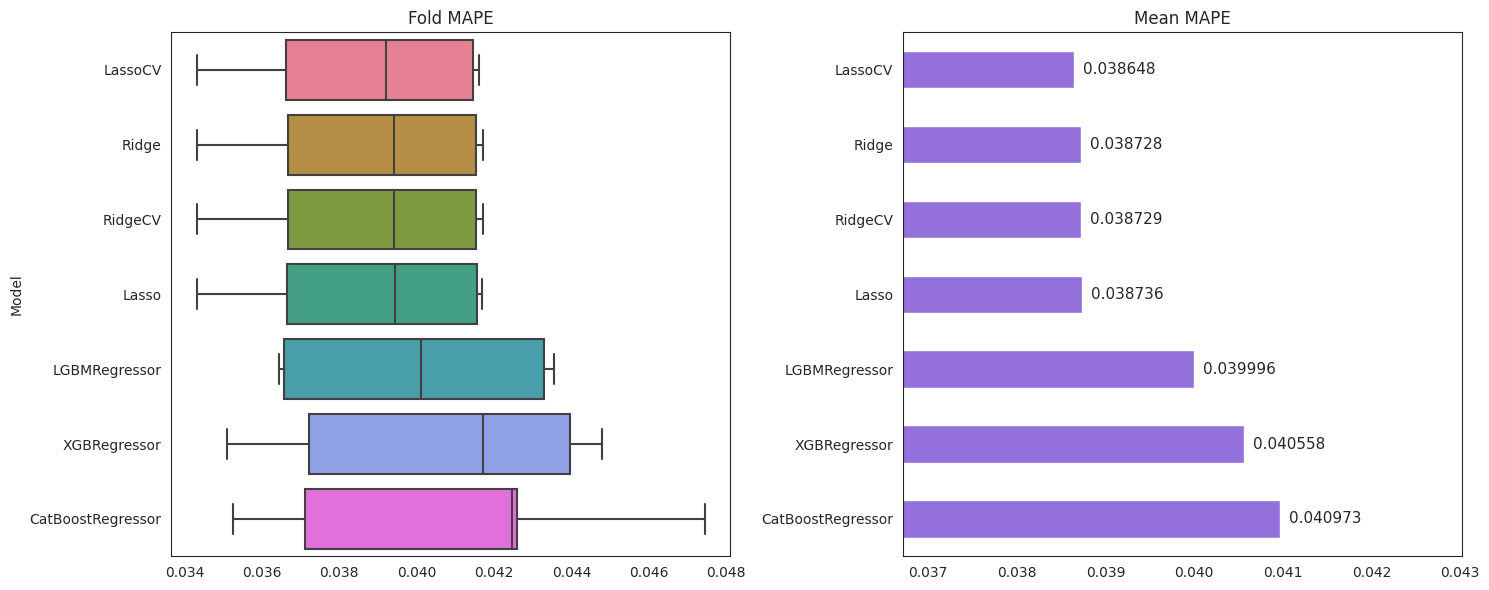

In [26]:
sns.set_style('white')
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(data=scores, orient='h', palette='husl', ax=axes[0], order=scores.mean().sort_values().index.tolist())
axes[0].set_title('Fold MAPE')
axes[0].set_xlabel('')
axes[0].set_ylabel('Model')

mean_scores = scores.mean().sort_values(ascending=False)
mean_scores.plot(kind='barh', ax=axes[1], color='#9370DB')
axes[1].set_title('Mean MAPE')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim([x_min, x_max])

for i, v in enumerate(mean_scores):
    axes[1].text(v + 1e-4, i, f'{v:.6f}', va='center', fontsize=11)

plt.tight_layout()
plt.show()

In [27]:
submission = pd.DataFrame({'id': test_ids, 'orders': lasso_cv_test_preds})
submission.to_csv(f'lassocv-mape_{np.mean(lasso_cv_scores)}.csv', index=False)

In [28]:
submission = submission.rename(columns={'id': 'warehouse'})
submission['date'] = submission['warehouse'].str.split('_').str[2]
submission['warehouse'] = submission['warehouse'].str.split('_').str[:2].str.join('_')

submission['date'] = pd.to_datetime(submission['date'], errors='coerce')
warehouses = submission['warehouse'].unique()
n_warehouses = len(warehouses)

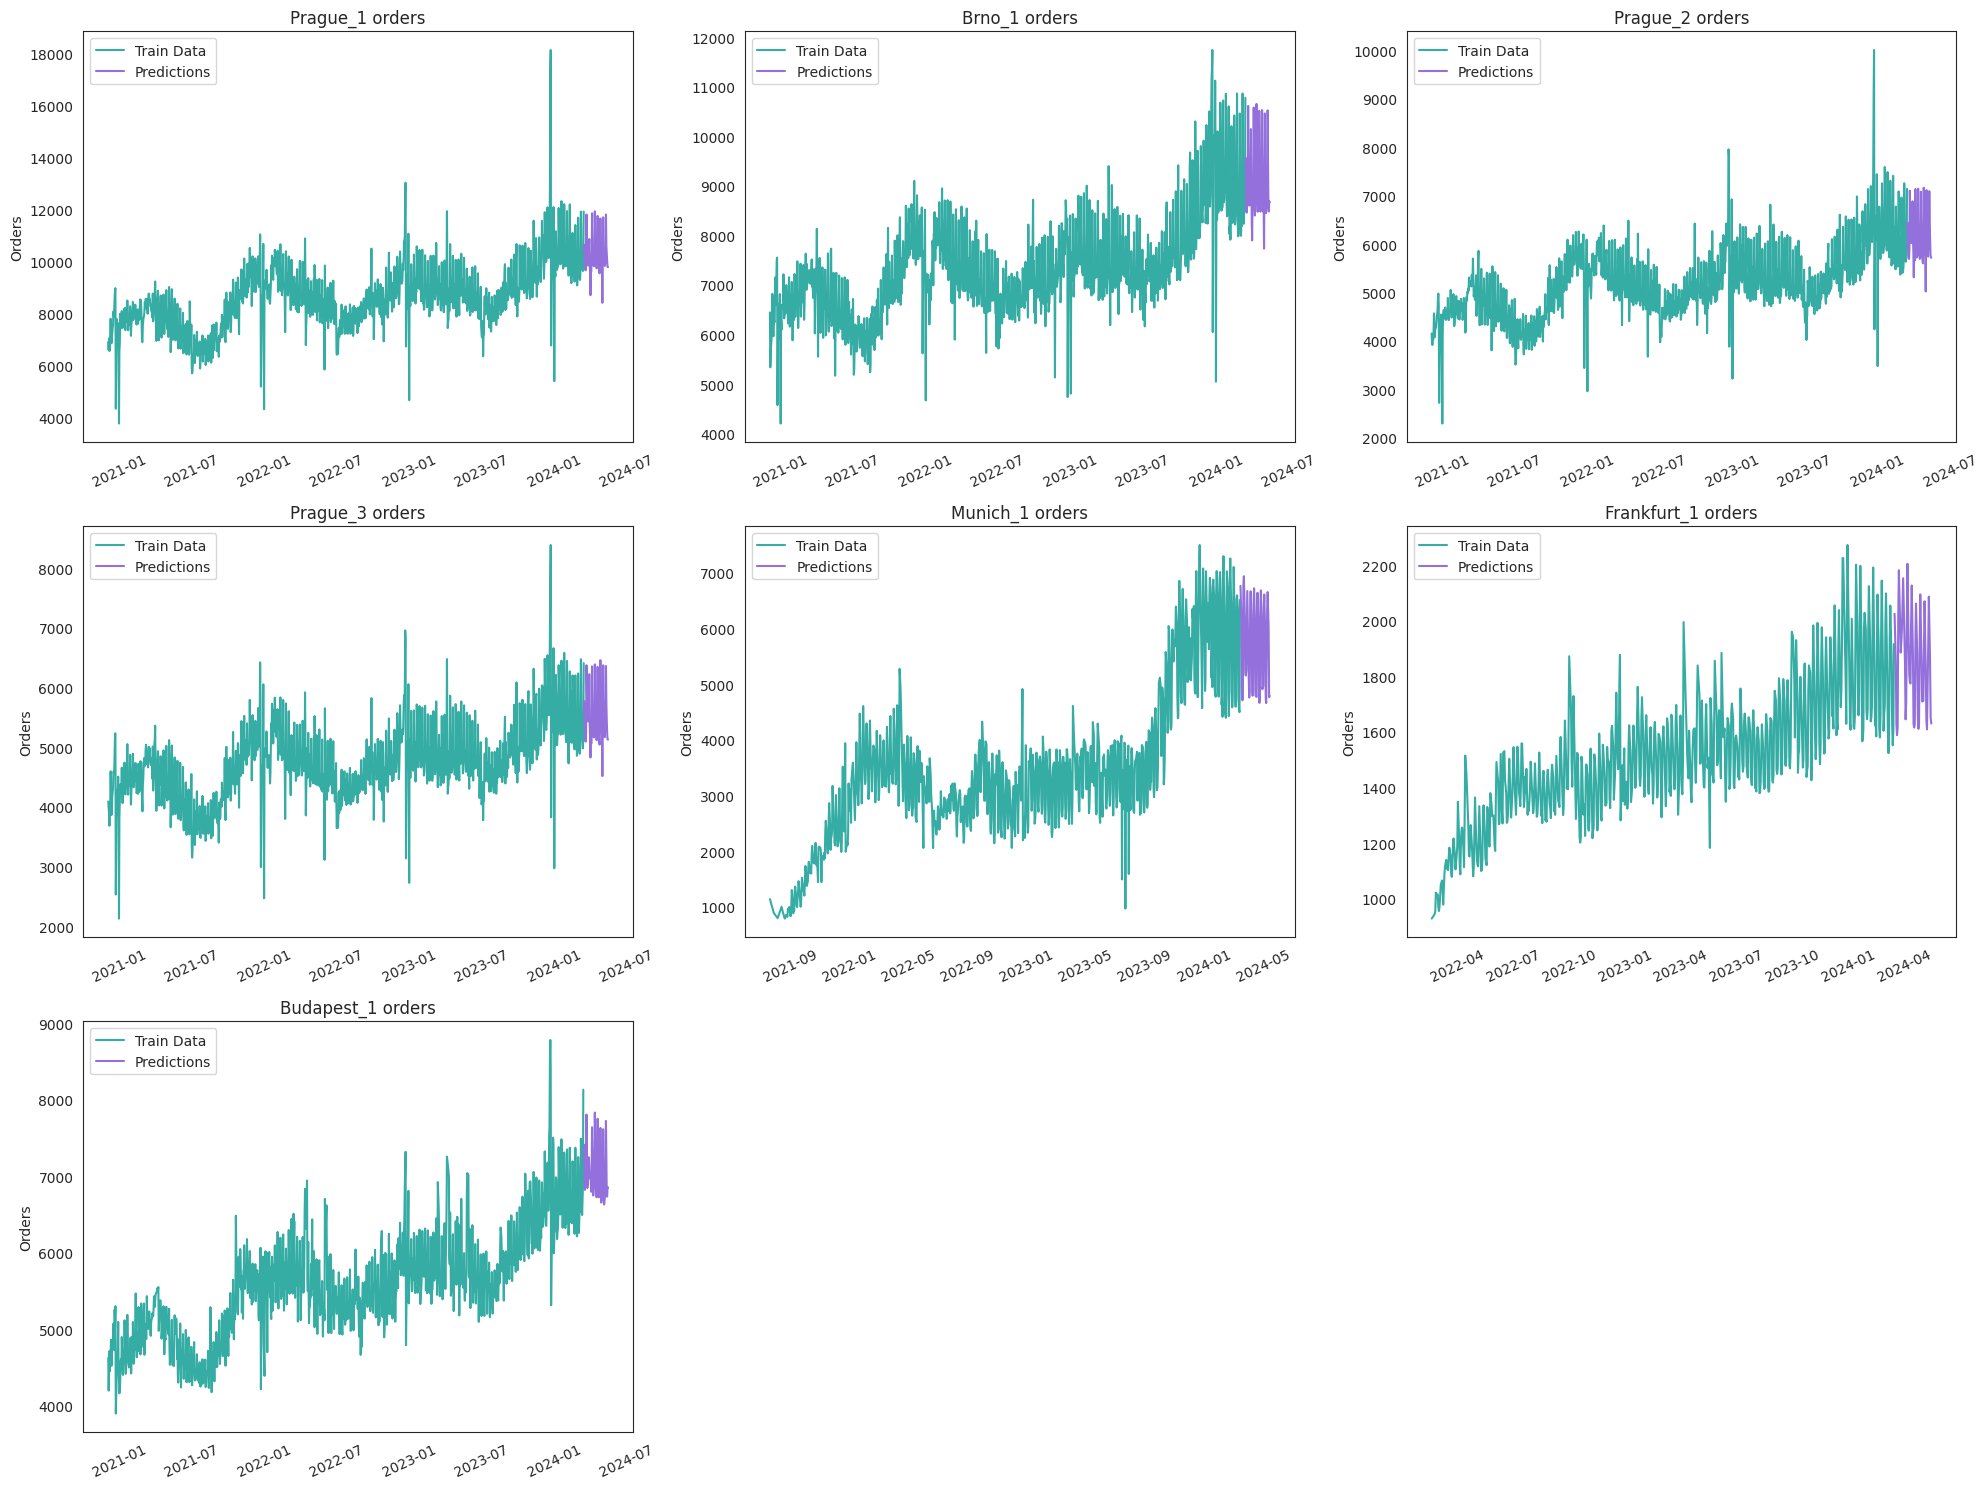

In [29]:
# This plot is based on https://www.kaggle.com/competitions/rohlik-orders-forecasting-challenge/discussion/511783
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

for ax, wh in zip(axes.flatten(), warehouses):
    wh_train = train[train['warehouse'] == wh][['warehouse', 'orders', 'date']].set_index('date')
    wh_submission = submission[submission['warehouse'] == wh][['warehouse', 'orders', 'date']].set_index('date')

    sns.lineplot(x=wh_train.index, y=wh_train['orders'], label='Train Data', ax=ax, color=sns.color_palette('husl')[3])
    sns.lineplot(x=wh_submission.index, y=wh_submission['orders'], label='Predictions', ax=ax, color='#9370DB')

    ax.set_title(f'{wh} orders')
    ax.set_xlabel('')
    ax.set_ylabel('Orders')
    ax.legend()
    ax.tick_params(axis='x', rotation=25)

axes[-1, -1].axis('off')
axes[-1, -2].axis('off')

plt.tight_layout()
plt.show()